## Useful Links
[Nibabel Basic Tutorial](https://nipy.org/nibabel/coordinate_systems.html)  
[Nibabel Analyze Image Documentation](https://nipy.org/nibabel/reference/nibabel.analyze.html)

In [1]:
import os
import skimage
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from nibabel.analyze import AnalyzeHeader

In [2]:
root = '../data/LPBA40/native_space'
subjects = ['S'+str(num) if num >= 10 else 'S0'+str(num) for num in range(1,40)]

In [3]:
f = open('../data/LPBA40/native_space/S01/S01.native.mri.hdr', 'rb')
binblock = f.read()
hdr = AnalyzeHeader(binblock)

image_shape = hdr.get_data_shape()
print('Shape :',image_shape)
width, height, depth, _ = image_shape

Shape : (256, 124, 256, 1)


In [4]:
f = open('../data/LPBA40/native_space/S01/S01.native.mri.img', 'rb')
raw_image = np.fromfile(f, np.uint16)
image = raw_image.reshape(image_shape).squeeze()
image.shape

(256, 124, 256)

In [5]:
image = skimage.transform.resize(image, (256,256,256), anti_aliasing=True)

In [6]:
def normalize(image):
    image = 2 * (image - image.min()) / (image.max() - image.min())-1
    return image

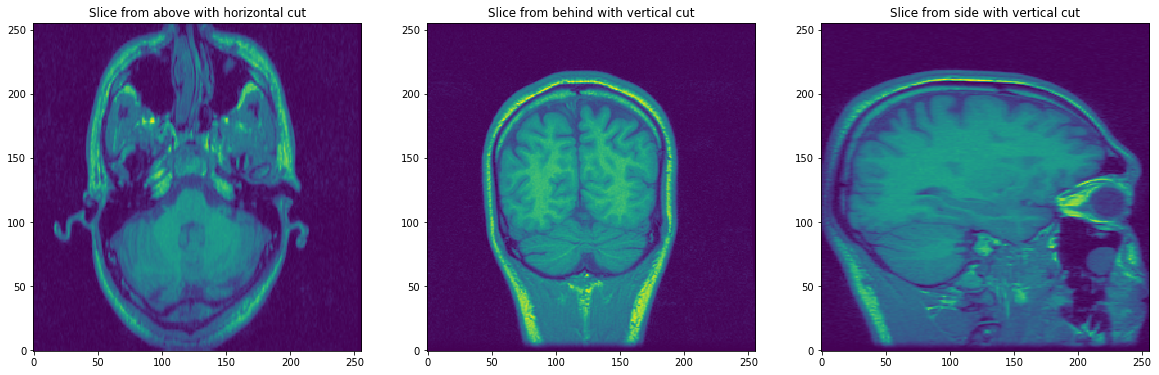

In [7]:
plt.figure(figsize=(20,20))

plt.subplot(131)
mri_slice = normalize(image[80, :, :])
plt.title('Slice from above with horizontal cut')
plt.imshow(mri_slice, cmap='viridis', origin='lower')

plt.subplot(132)
mri_slice = normalize(image[:, 57, :])
plt.title('Slice from behind with vertical cut')
plt.imshow(mri_slice, cmap='viridis', origin='lower')

plt.subplot(133)
mri_slice = normalize(image[:, :, 150])
plt.title('Slice from side with vertical cut')
plt.imshow(mri_slice, cmap='viridis', origin='lower')

From the above images, most likely only perform registration on images from the first two cuts 

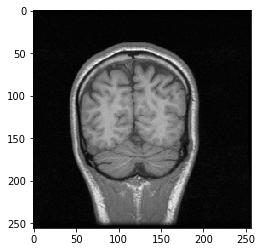

In [8]:
# if we want the first index to be the batch index, transpose array
image = image.swapaxes(0,1)

# flip image to be right side up
image = image [:, ::-1]

# Normalize image into range [0,1]
image = (normalize(image)+1)/2

plt.imshow(normalize(image[57]), cmap='gray')

In [9]:
from torchvision import transforms
from PIL import Image

In [10]:
tfms = transforms.Compose([
    # Convert to PIL Image
    transforms.ToPILImage("F"),
    
    transforms.RandomAffine(90, (0.2,0.2), (0.6,0.9), 5, Image.BILINEAR),
    # rotate: +/- 90 degrees
    # translate: 0.2*H, 0.2*W
    # Resize: 0.4 - 0.9
    # Sheer 5 degrees
    # Bilinear resampling
    
    transforms.ToTensor(),
    
    # Add other transforms here
])

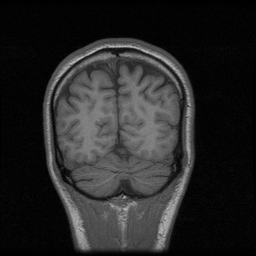

In [11]:
a=(image[57]*(2**8-1)).astype('float32')
Image.fromarray(a).convert("L")

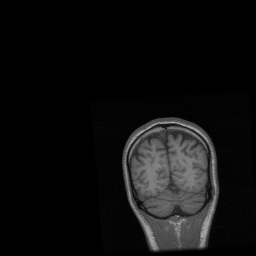

In [12]:
Image.fromarray(tfms(a).numpy().squeeze()).convert("L")

## Convert to Torch Dataset

In [13]:
from torch.utils.data import Dataset, DataLoader
import os, torch

In [14]:
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
#     image *= 255
    return image.astype('float32')

class MRIDataset(Dataset):
    def __init__(self, root, transform=None, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        # Could use PIL here to avoid all the reshaping/transforming...
        image = image.swapaxes(0,1)
        image = image[:, ::-1]
        image = image[slice_number]
        image = normalize(image)

        if self.transform is not None:
            target = torch.Tensor((image-self.transform.transforms[-1].mean[0])/
                                    self.transform.transforms[-1].std[0])
            tf_image = self.transform(image)
        else: 
            return image
            
        return tf_image, target

In [15]:
data=MRIDataset("../data/LPBA40/native_space")

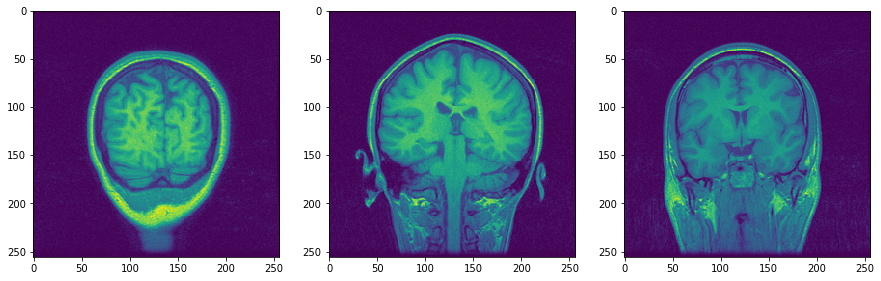

In [16]:
f, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,10))
ax0.imshow(data[20])
ax1.imshow(data[49])
ax2.imshow(data[789])

In [17]:
tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(45, (0.2,0.2), (0.6,0.9), 5, Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.1408],[0.1716])
])

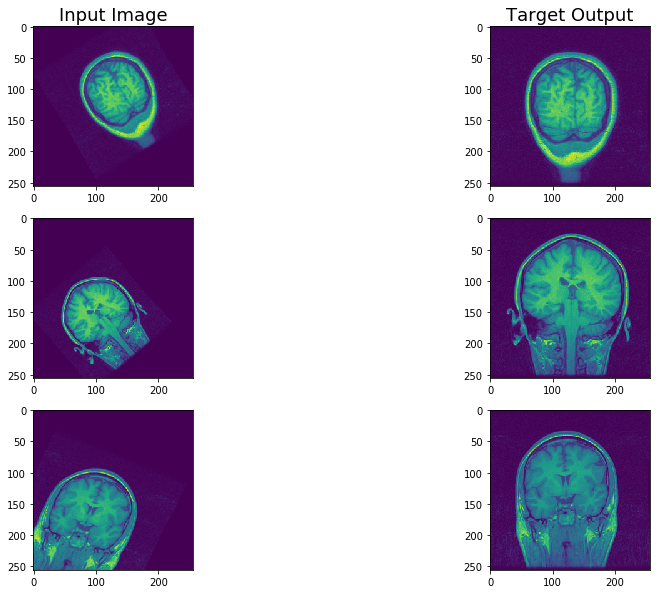

In [18]:
data=MRIDataset("../data/LPBA40/native_space",tfms)
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,10))
ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(data[20][0].numpy().squeeze())
ax1[0].imshow(data[49][0].numpy().squeeze())
ax2[0].imshow(data[789][0].numpy().squeeze())

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(data[20][1].numpy().squeeze())
ax1[1].imshow(data[49][1].numpy().squeeze())
ax2[1].imshow(data[789][1].numpy().squeeze())

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dl = DataLoader(data, batch_size=8,
                        shuffle=True, num_workers=4)

In [20]:
a=next(iter(dl))
a[0].shape, a[1].shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 256, 256]))

In [21]:
a[0].mean(), a[0].std(), a[0].max()

(tensor(-0.2179), tensor(1.1288), tensor(4.8282))

In [22]:
a[1].mean(), a[1].std(), a[1].max()

(tensor(0.0903), tensor(1.2770), tensor(5.0070))

## STN

In [23]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Add more loss functions

In [25]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.ReLU(True)
        )
        self.output_size = ((image_size-7)//2+1-5)//2+1

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        # A final layer to adjust for interpolation
        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        res_out = self.conv1(x)
        x = x + res_out
        
        return x

model = Net(256).to(device)

In [26]:
optimizer = optim.SGD(model.parameters(), lr=0.005)
loss_fn = nn.L1Loss()


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(dl):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl.dataset),
                100. * batch_idx / len(dl), loss.item()))

# Not used
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [27]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(dl))
        moving, target = data[0].to(device), data[1].cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor = model(moving).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target[:,None]))
        
        # Plot the results side-by-side
        f, axarr = plt.subplots(3, 1, figsize=(15,8))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Output Images')
        
        axarr[2].imshow(target_grid)
        axarr[2].set_title('Target Images')

Train Epoch: 1 [0/4800 (0%)]	Loss: 0.813659
Train Epoch: 1 [4000/4800 (83%)]	Loss: 0.691651


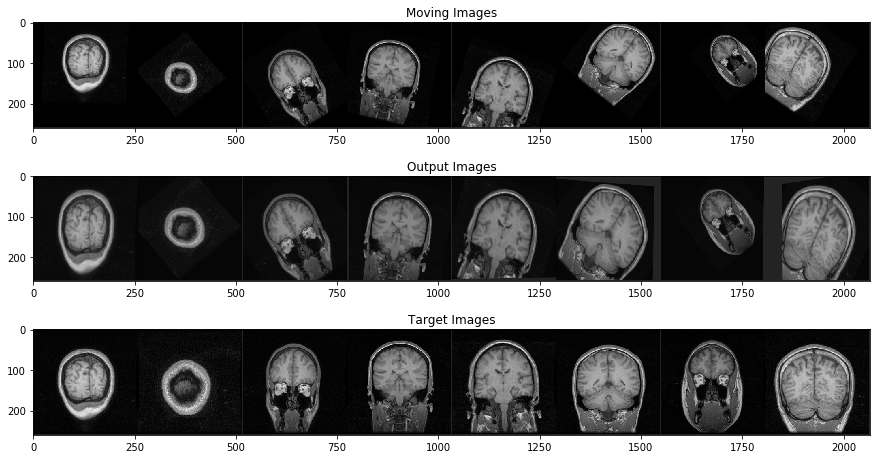

In [28]:
for epoch in range(1, 3):
    train(epoch)
#     test()

# Visualize the STN transformation on some input batch
visualize_stn()

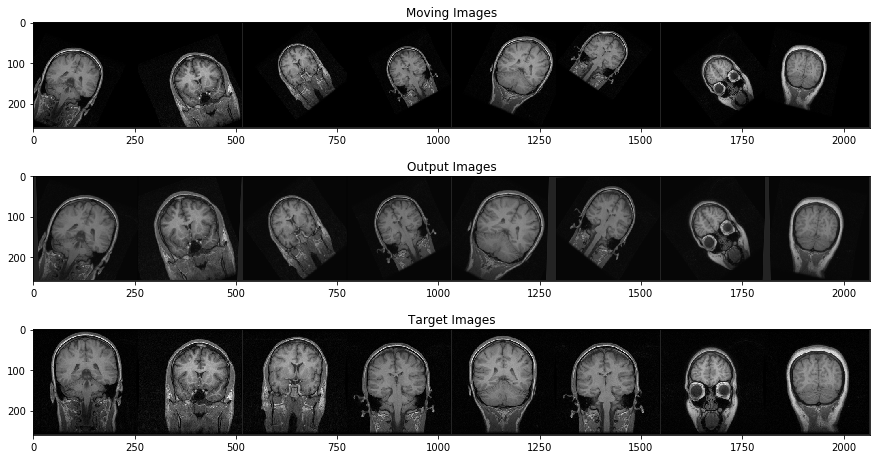

In [29]:
visualize_stn()

Todo:

- Train for longer
- Create different loss functions
- Compare to SimpleElastix Image library
- Add masks and calculate other losses (Jaccard, MI, ROC)